In [939]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [940]:
%matplotlib inline

In [941]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

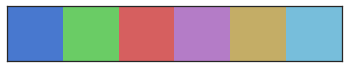

In [942]:
import seaborn as sns
sns.set_style("white")
pal = sns.color_palette('muted')
sns.palplot(pal)

In [943]:
plt.rcParams.update({
    'figure.autolayout': False,
    'figure.figsize'   : (15,9),
    'font.size'        : 20,         # default font size (to match the above figsize)
    'font.family'      : 'serif',    # avoid sns warning
    'axes.titlesize'   : 'medium',
    'axes.labelsize'   : 'medium',
    'ytick.labelsize'  : 'small',  # font size relative to the default
    'xtick.labelsize'  : 'small',
    'legend.fontsize'  : 'small'
})

In [944]:
from utils import                   \
    get_filtered_df,                \
    df_resilience, word_resilience, \
    load_google_counts

### Functions

In [945]:
import numba

In [946]:
@numba.jit(nopython=True)
def jaccard(y1, y2):
    """ Returns the Jaccard distance between two years (numpy arrays of True/False) """
    return 1 - (y1 & y2).sum() / (y1 | y2).sum()

In [947]:
def kernel_dist(y1, y2):
    """Returns the kernel distance between years y1, y2 from the DataFrame of **RANKS** (NOT normalised)"""
    return np.abs(y1 - y2).sum()

In [948]:
def get_distances(d, f):
    """ Returns the 'matrix' of distances between any 2 rows of `d`, computed with `f(d, row1, row2)` """
    j = pd.DataFrame(index=d.index, columns=d.index, dtype=np.float64)
    
    for idx_y1, year1 in enumerate(d.index):
        if idx_y1 % 10 == 0:
            print(year1, end=' ')
        y1_values = d.loc[year1].values
        
        for year2 in d.index[idx_y1+1 : ]:
            j.loc[year1, year2] = f(y1_values, d.loc[year2].values)
    return j

In [949]:
def get_dist_vs_time(d):
    """ Given an upper triangular dataframe, melts it into one that can be plotted """
    r = d.reset_index().rename(columns={'index':'year_src'})
    r = pd.melt(r, id_vars='year_src', var_name='year_dst', value_name='distance').dropna()
    r['time_diff'] = r.year_dst - r.year_src
    return r

### Load data

Define de parameters for the current session:

In [1108]:
N = 1
lang = 'eng'
start_year = 1800
end_year = 2012
notebook_run_start = time.time()

In [1109]:
def get_title(title):
    return '{t} ({l}, {n}-grams)'.format(t=title, l=lang, n=N)

In [1110]:
word_counts = load_google_counts(lang, N, start_year, end_year)
len(word_counts.keys())

267489

In [1111]:
w = pd.DataFrame(word_counts)
w.index += start_year
w = w.loc[:2008]
ress = df_resilience(w)

# Corpus size

To be able to better understand all variables, let's have a look at the corpus size

In [954]:
w_gby_res = w.groupby(lambda col: ress[col] - ress[col] % 50 + 50, axis='columns')
sizes_res = w_gby_res.apply(lambda group_df: group_df.sum(axis='columns'))

In [955]:
df_resilience(w_gby_res.get_group(250)).min()

200

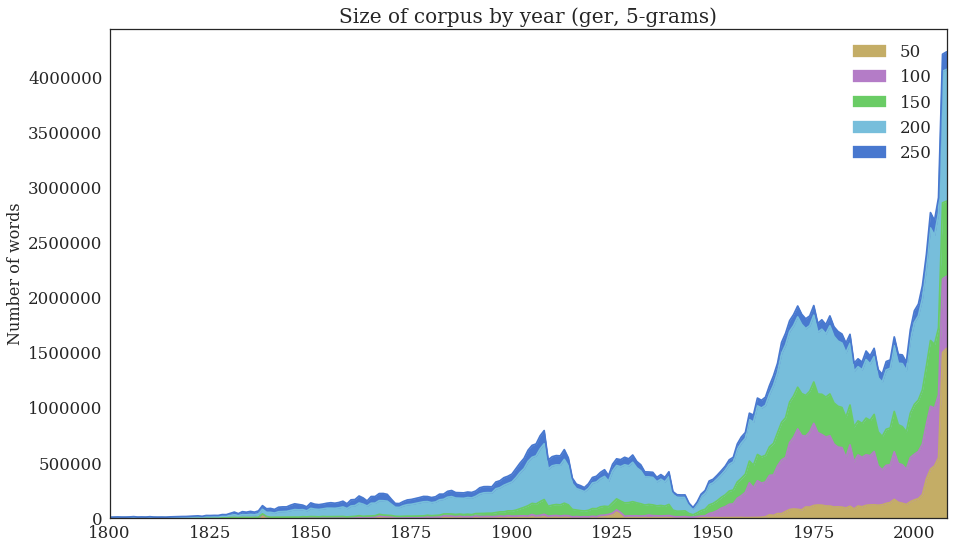

In [956]:
sns.set_palette(sns.set_palette([pal[4], pal[3], pal[1], pal[5], pal[0], pal[2]]))
sizes_res.plot.area(title=get_title('Size of corpus by year'))
plt.ylabel('Number of words', fontsize=16)

if N == 1:
    plt.savefig('figures/{l}-{n}-size-res1.jpg'.format(l=lang, n=N))
sns.set_palette(pal)

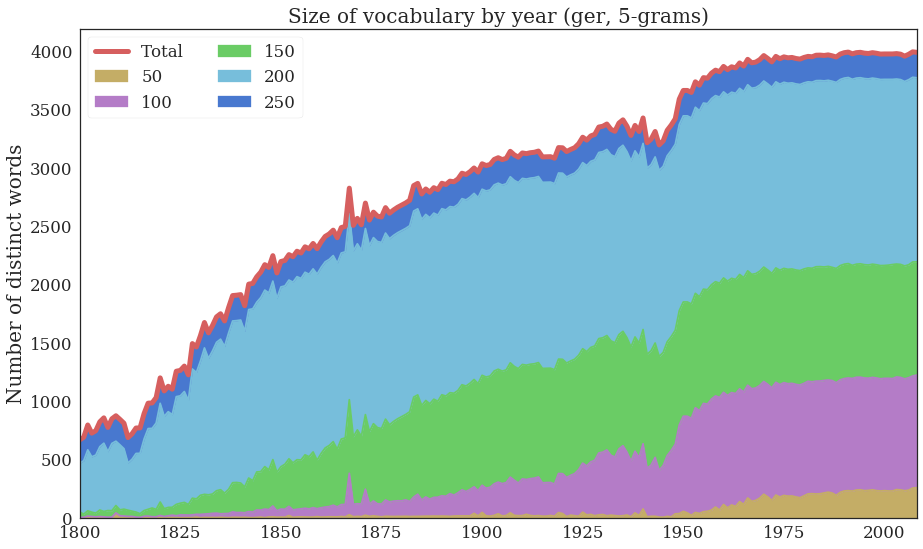

In [957]:
sns.set_palette([pal[4], pal[3], pal[1], pal[5], pal[0], pal[2]])
vocab_res = w_gby_res.apply(lambda group_df: (group_df > 0).sum(axis='columns'))
vocab_res.plot.area(title=get_title('Size of vocabulary by year'))

_total_vocab = vocab_res.sum(axis='columns')
_total_vocab.name = 'Total'
_total_vocab.plot(linewidth=5)

plt.ylabel('Number of distinct words')
plt.legend(ncol=2, frameon=True)

plt.savefig('figures/{l}-{n}-vocab-res1.jpg'.format(l=lang, n=N))
sns.set_palette(pal)

### Jaccard distance

We compute the distances between every pair of years and put everything in a **long** dataframe

$d_J(L_i, L_j) = 1 - \frac{\left| L_i \cap L_j \right|}{\left| L_i \cup L_j \right|} $

| L |   |   |   |   |
|---|---|---|---|---|
| 1 | a | b | c | d |
| 2 | a | b | c | e |
| 3 | d | c | b | a |

In [958]:
df, ranks = get_filtered_df(w, quantile=None)

Got 4037 words
Filtered down to 4037 words


For jaccard, we transform it into booleans:

In [959]:
df = df != 0

In [960]:
j = get_distances(df, jaccard)

1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 

In [961]:
jplot = get_dist_vs_time(j)

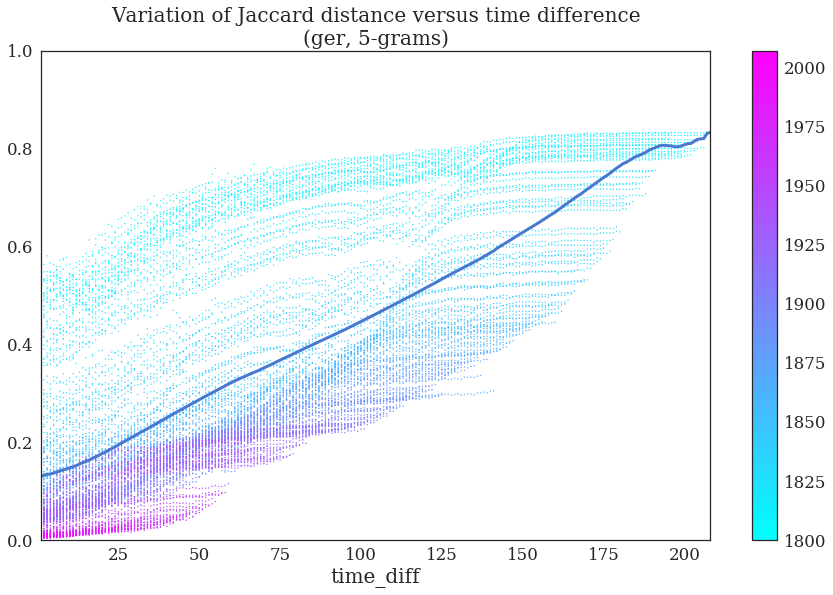

In [962]:
plt.title('Variation of Jaccard distance versus time difference\n({l}, {n}-grams)'.format(l=lang, n=N))
plt.ylim(0, 1)
sc = plt.scatter(jplot.time_diff, jplot.distance, s=1, c=jplot.year_src, cmap='cool')
jplot.groupby('time_diff').distance.mean().plot(linewidth=3)
plt.colorbar(sc)
plt.savefig('figures/{l}-{n}-jac-td.jpg'.format(l=lang, n=N))

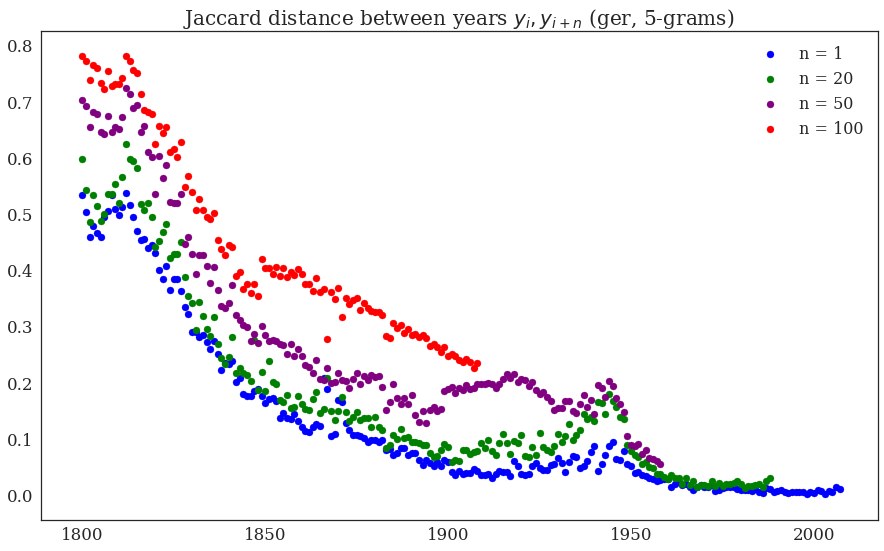

In [963]:
plt.title(get_title('Jaccard distance between years $y_i, y_{{i+n}}$'))
for n, c in {1:'blue', 20:'green', 50:'purple', 100:'red'}.items():
    jplot_n = jplot[jplot.time_diff == n]
    plt.scatter(jplot_n.year_src, jplot_n.distance, c=c, label='n = %d' % n)
plt.legend(fontsize=16)
plt.savefig('figures/{l}-{n}-jac-y.png'.format(l=lang, n=N))

### Kernel distance

In [964]:
kernel_resilience = 200

In [965]:
def plot_kernel(k_rnk, norm_num_items):
    ''' Makes the plots for kernel distance from the rank matrix '''    
    kj = get_distances(k_rnk, kernel_dist)

    # normalise
    n = np.arange(norm_num_items)
    norm_factor = np.abs(n - n[::-1]).sum()
    kj = kj / norm_factor

    # prepare plot -- long DF
    kj_plot = get_dist_vs_time(kj)

    # plot 1 -- time differences
    plt.figure()
    plt.ylim(0, 1)
    plt.title('Variation of Kernel distance versus time difference\n({l}, {n}-grams)'.format(l=lang, n=N))
    plt.scatter(kj_plot.time_diff, kj_plot.distance, s=1, c=kj_plot.year_src, cmap='cool')
    kj_plot.groupby('time_diff').distance.mean().plot(linewidth=3)
    plt.colorbar()
    plt.savefig('figures/{l}-{n}-ker-td.jpg'.format(l=lang, n=N))

    # plot 2 -- change velocity
    plt.figure()
    plt.title(get_title('Kernel distance between years $y_i, y_{{i+n}}$'))
    for n, c in {1:'blue', 20:'green', 50:'purple', 100:'red'}.items():
        kj_plot_n = kj_plot[kj_plot.time_diff == n]
        plt.scatter(kj_plot_n.year_src, kj_plot_n.distance, c=c, label='n = %d' % n)
    plt.legend(fontsize=16)
    plt.savefig('figures/{l}-{n}-ker-y.jpg'.format(l=lang, n=N))
    
    return kj_plot

We start with a new DF because `d` above was turned into `True`/`False` for Jaccard and this time we need the actual frequencies

We consider as kernel the words with MAX resilience, i.e. which appear in all years

For kernel distance need to compute ranks. These are incremental from lowest to highest frequency

However, we can compute the ranks only among kernel words or among all words. We look at both cases

$d_K(L_i, L_j) = \Sigma_{w \in K} \left| Rank(w, i) - Rank(w, j) \right| $

| L    |   |   |   |   |
|------|---|---|---|---|
| **1800** | a | b | c | d |
| **1900** | a | d | c | b |
| **2000** | d | c | b | a |

In [1112]:
k, _total_ranks = get_filtered_df(w, quantile=None)
ress = df_resilience(k)

Got 267489 words
Filtered down to 267489 words


First we use the ranks among **all** words (of the kernel ones). 

Note the normalisation is bigger than if we ranked among kernel only !! 

In [1002]:
k_rnk = k.rank(axis='columns', method='first')  # rank among all words
k_rnk = k_rnk.loc[:, ress > kernel_resilience]  # keep just the kernel ones

1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 

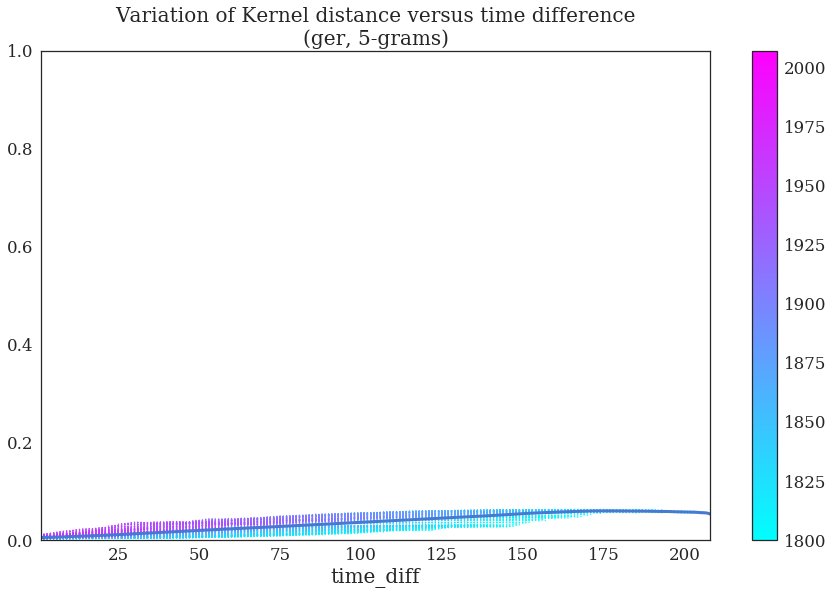

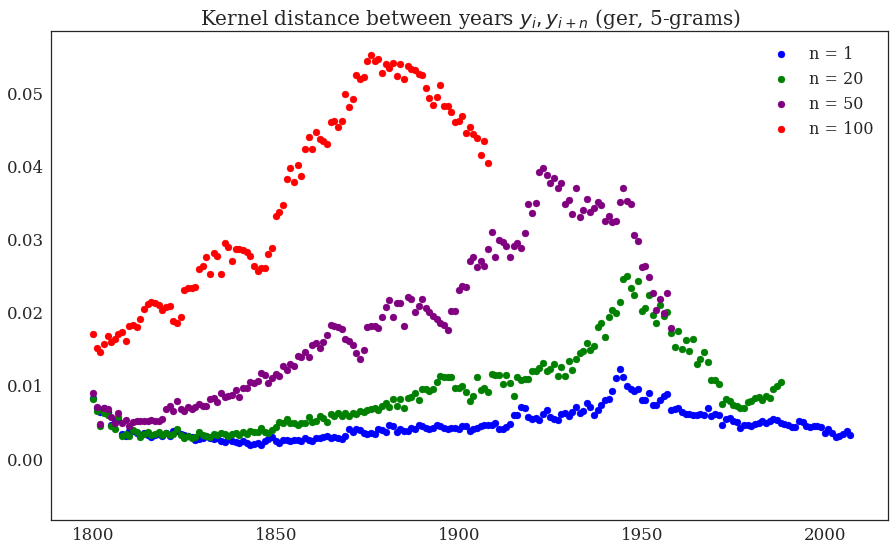

In [968]:
kj_plot = plot_kernel(k_rnk, len(k.columns))

Then, we use the ranks **only** among kernel words. 

In [1113]:
k_rnk = k.loc[:, ress > kernel_resilience]         # get kernel
k_rnk = k_rnk.rank(axis='columns', method='first') # rank only among kernel

1800 1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 

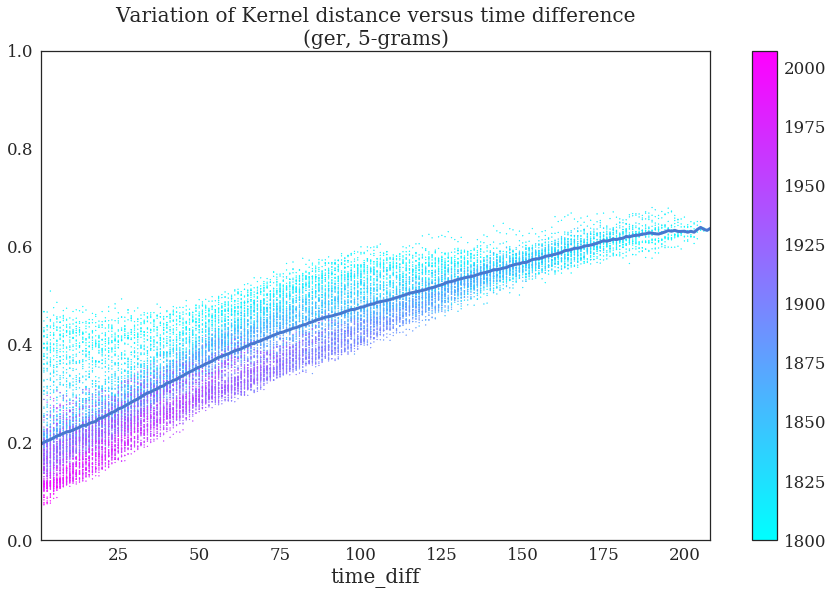

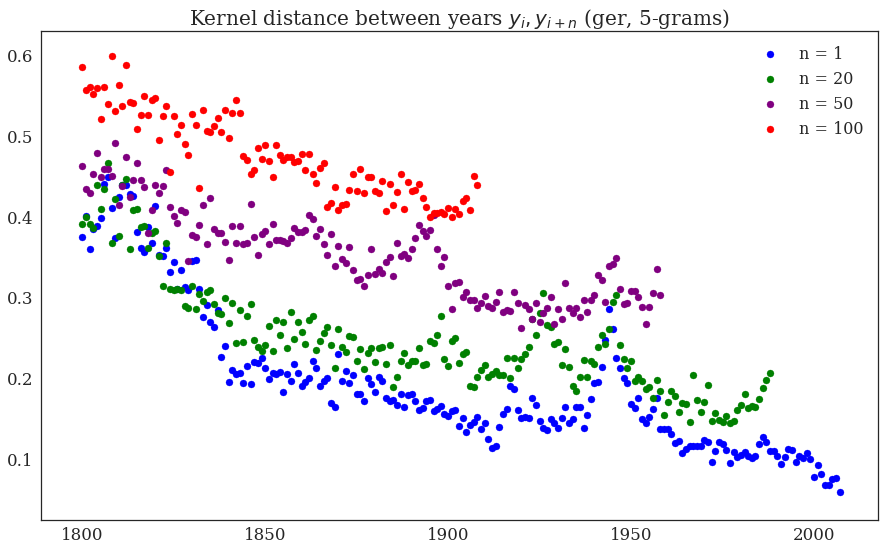

In [970]:
kj_plot = plot_kernel(k_rnk, norm_num_items=len(k_rnk.columns))

### Side by side comparison

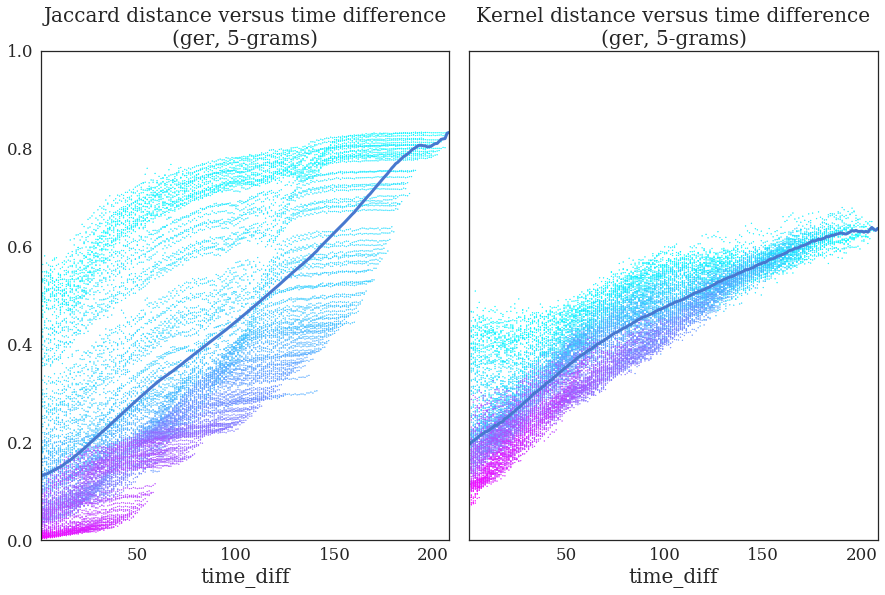

In [971]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.subplots_adjust(wspace=0.05)
ax1.set_ylim(0,1)

# Jaccard
ax1.set_title('Jaccard distance versus time difference\n({l}, {n}-grams)'.format(l=lang, n=N))
ax1.scatter(jplot.time_diff, jplot.distance, s=1, c=jplot.year_src, cmap='cool')
jplot.groupby('time_diff').distance.mean().plot(linewidth=3, ax=ax1)

# Kernel
ax2.set_title('Kernel distance versus time difference\n({l}, {n}-grams)'.format(l=lang, n=N))
ax2.scatter(kj_plot.time_diff, kj_plot.distance, s=1, c=kj_plot.year_src, cmap='cool')
kj_plot.groupby('time_diff').distance.mean().plot(linewidth=3, ax=ax2)

plt.savefig('figures/{l}-{n}-cmp-td.jpg'.format(l=lang, n=N))

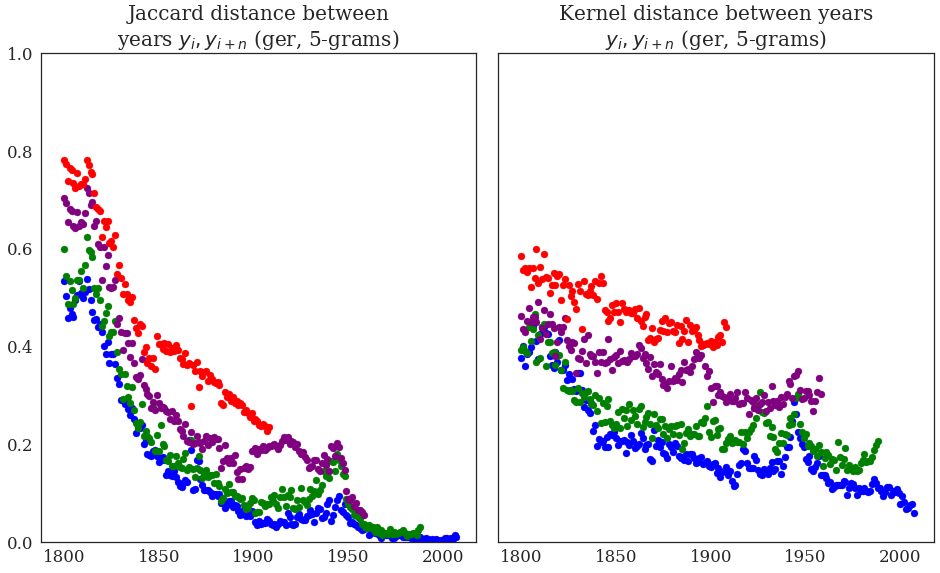

In [972]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 9))
f.subplots_adjust(wspace=0.05)
ax1.set_ylim(0,1)

# Jaccard
ax1.set_title("Jaccard distance between\nyears $y_i, y_{{i+n}}$ ({l}, {n}-grams)".format(l=lang, n=N))
for n, c in {1:'blue', 20:'green', 50:'purple', 100:'red'}.items():
    jplot_n = jplot[jplot.time_diff == n]
    ax1.scatter(jplot_n.year_src, jplot_n.distance, c=c, label='n = %d' % n)

# Kernel
ax2.set_title("Kernel distance between years\n$y_i, y_{{i+n}}$ ({l}, {n}-grams)".format(l=lang, n=N))
for n, c in {1:'blue', 20:'green', 50:'purple', 100:'red'}.items():
    kj_plot_n = kj_plot[kj_plot.time_diff == n]
    ax2.scatter(kj_plot_n.year_src, kj_plot_n.distance, c=c, label='n = %d' % n)
    
plt.savefig('figures/{l}-{n}-cmp-y.jpg'.format(l=lang, n=N))

# Where does the difference come from ?

Some words are more stable than others. So let's look at which words jiggle around the most, i.e. which ones have the highest rank variance

In [1114]:
k_var = k_rnk.var(axis='rows').sort_values()
print(k_var.head(20)) # 20 most  stable 
print(k_var.tail(20)) # 20 least stable

a       0.000000
in      0.000000
of      0.000000
and     0.000000
the     0.000000
to      0.000000
that    0.248666
is      0.327659
have    0.779352
it      0.784321
we      1.652512
not     1.886640
were    2.020289
with    2.040992
from    2.116443
be      2.571862
had     2.576325
they    3.021393
but     3.027006
was     3.221384
dtype: float64
korea           8.393458e+08
buses           8.471815e+08
hispanic        8.507490e+08
exploitation    8.616264e+08
skills          8.618402e+08
mev             8.644439e+08
homeland        8.696753e+08
seattle         8.743157e+08
coding          8.838638e+08
intake          9.289781e+08
processed       9.294529e+08
minimal         9.308487e+08
rna             9.390281e+08
radium          9.643664e+08
proton          9.701323e+08
technique       1.011285e+09
electron        1.064562e+09
immune          1.076734e+09
amino           1.154722e+09
hitler          1.210222e+09
dtype: float64


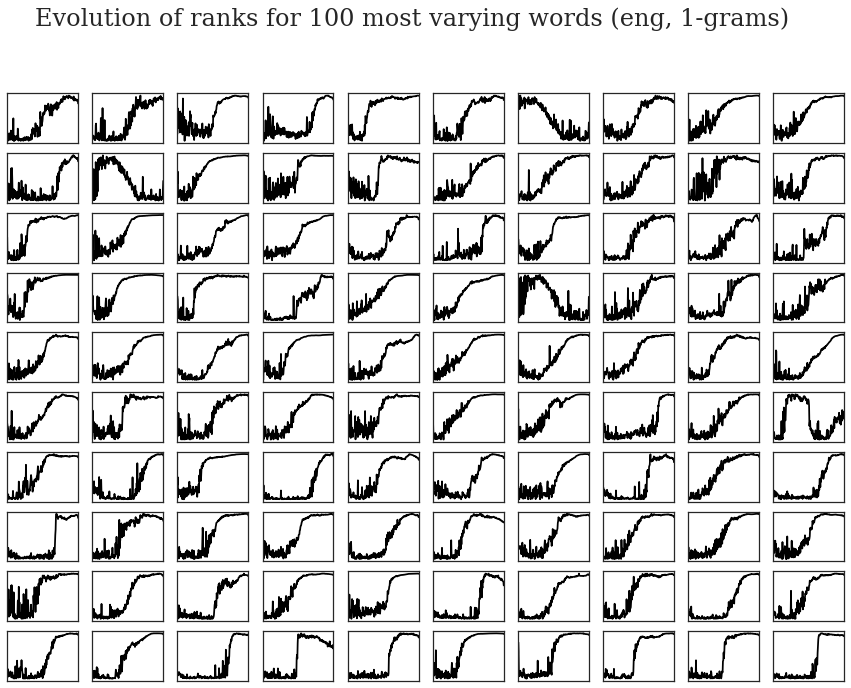

In [1115]:
sns.set_palette([(0, 0, 0)])
axes = k_rnk.loc[:, k_var.tail(100).index].plot(subplots=True, figsize=(15, 12), layout=(10,10), legend=True, 
                                                title=get_title('Evolution of ranks for 100 most varying words'))
for ax in axes.flatten():
    ax.set_yticks([])
    ax.set_xticks([])
#     ax.set_title(ax.get_legend_handles_labels()[1][0])
    ax.legend(())
sns.set_palette(pal)

In [1116]:
k_var.tail(100).to_csv('out_files/{l}-{n}-least.csv'.format(l=lang, n=N))

In [ ]:
# also print to file
with open('out_files/{l}-{n}-stable.txt'.format(l=lang, n=N), 'w') as f:
    print(k_var.head(20), file=f) # 20 most  stable 
    print(k_var.tail(20), file=f) # 20 least stable    

Ok, so we see the top 2 never move from their spot. That means that most of the "distance" comes from the tail of the distribution. 

While those can move around a lot, let's see if there are any words which follow a certain trend (ascending/descending). For that, we fit a simple linear model and take only those with high positive/negative coefficients

In [974]:
from sklearn.linear_model import LinearRegression as LR

In [975]:
r = LR()
coeffs = pd.Series()
x = k.index.values.reshape(-1,1)
num_neg, num_pos = 0, 0
for word in reversed(k_var.index):
    r.fit(x, k_rnk[word].values.reshape(-1, 1))
    coeffs[word] = r.coef_[0,0]
    if r.coef_[0,0] < 0:
        num_neg += 1
    else:
        num_pos += 1
    if num_neg > 10 and num_pos > 10:
        break

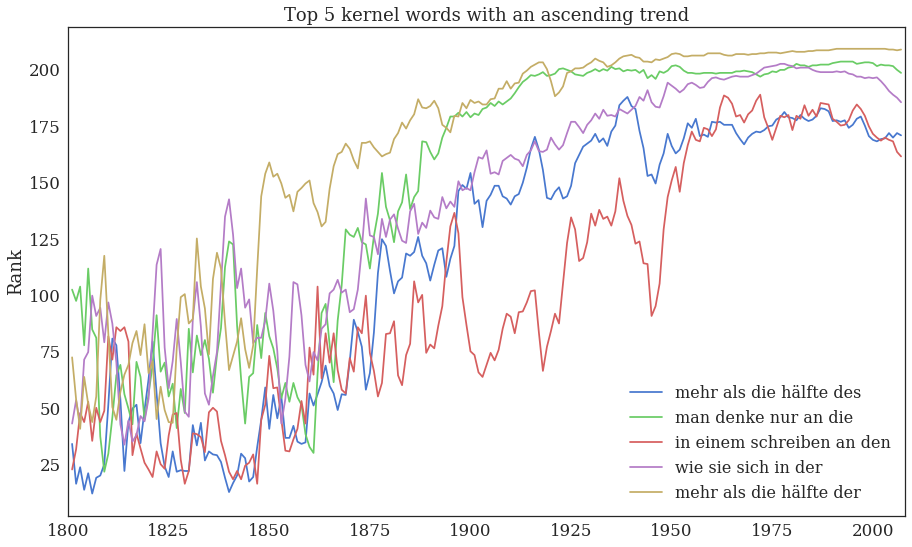

In [976]:
plt.figure(figsize=(15,9))
for word, coeff in coeffs.sort_values(ascending=False)[:5].iteritems():
    k_rnk[word].rolling(3, center=True).mean().plot(label=word)

plt.legend(fontsize=16)
plt.title('Top 5 kernel words with an ascending trend', fontsize=18)
plt.ylabel('Rank', fontsize=18)
plt.savefig('figures/{l}-{n}-rank-up.jpg'.format(l=lang, n=N))

And for the *downward* trend:

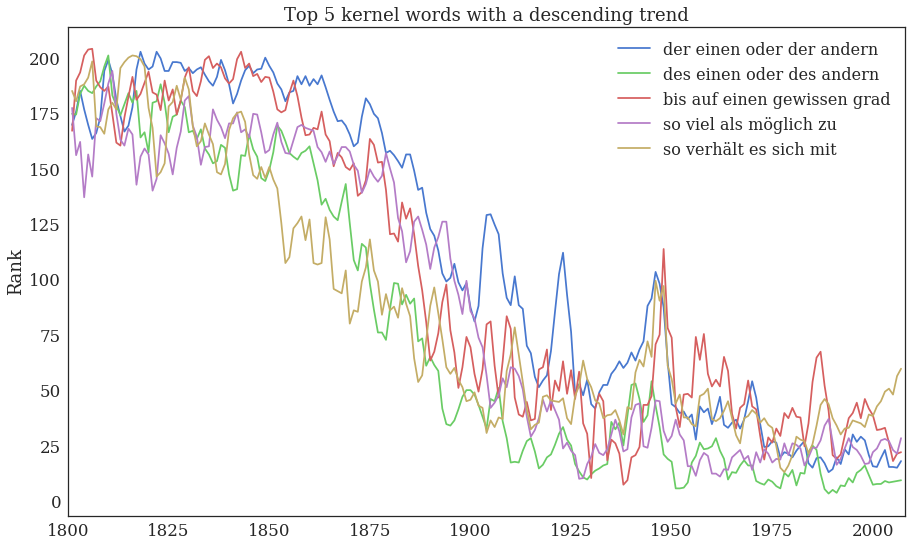

In [977]:
plt.figure(figsize=(15,9))
for word, coeff in coeffs.sort_values()[:5].iteritems():
    k_rnk[word].rolling(3, center=True).mean().plot(label=word)
plt.title('Top 5 kernel words with a descending trend', fontsize=18)
plt.ylabel('Rank', fontsize=18)
plt.legend(fontsize=16)
plt.savefig('figures/{l}-{n}-rank-down.jpg'.format(l=lang, n=N))

# Chronoclouds

In [978]:
from chronocloud_final import go

In [996]:
N = 4
lang = 'eng'

In [997]:
resolution = 3000
go(lang, N, resolution)

step 1: done / 0:00:26.134726
step 2: done / 0:01:29.538944
chronocloud legend: done
chronocloud noyau: done
chronocloud R=125: done
chronocloud R=100: done
chronocloud R=75: done
chronocloud R=50: done
chronocloud "eng": done / 0:03:00.041916


In [991]:
from IPython.display import Image
import random

img_path = './chrono_images/{l}_{n}_{res}_final_chronocloud.png'.format(l=lang, n=N, res=resolution)
print(img_path)
Image(url=img_path+'?'+str(random.random()))

./chrono_images/eng_1_3000_final_chronocloud.png


In [981]:
print("Total run time:", time.time() - notebook_run_start)

Total run time: 71.2197916507721
